In [94]:
# MODULE IMPORTS
import sys
sys.path.append('..')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#IMPORT ALL METHODS FOR PROBE
from methods.probe_methods import *
from pathfinder import path_finder

In [95]:
#Initialize device name
DEVICE_NAME = "BDOT 1"

#Tweak funny features about the .csv files collected by the 'scope
skiprows = 4 #have to skip the top 4 rows :(
time_key = "Time" #column header for time information
volt_key = "Ampl" #column header for voltage information

#Units of display
v_units = "V" #voltage in volts
t_units = "s" #time in seconds

In [96]:
# SELECT SHOTS FOR ANALYSIS
shot_nos = [1, 2, 3] #user-specified

# Create dictionary of shot paths
shot_path_dict = {}
for shot_no in shot_nos:
    #For each shot number, use the PATHFINDER function to return path to shot data
    shot_path_dict[shot_no] = path_finder(DEVICE_NAME, shot_no)

# HARDCODED- TO BE REMOVED
shot_path_dict = {
    1:"../example_data/data/C1--XX_SCOPE2--00081.csv", 
    2:"../example_data/data/C1--XX_SCOPE2--00081.csv",
    3:"../example_data/data/C1--XX_SCOPE2--00081.csv",
}

['Time' 'Ampl']


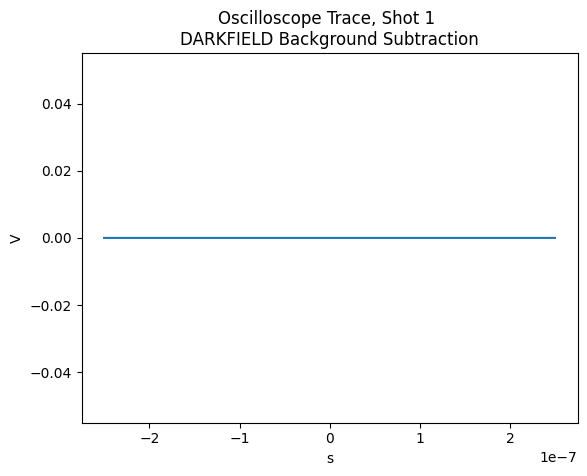

In [ ]:
########################################################
# PLOT OSCILLOSCOPE TRACE, WITH OR WITHOUT BKG REMOVAL #
########################################################

#user input: which shot is the raw shot? 
raw_shot_no = 1
bkg_shot_no = 3
bkg_name = "DARKFIELD"
bkg_removal = True

#Get raw shot data from specified shot and then extract voltage/time data
raw_shot_df = pd.read_csv(shot_path_dict[raw_shot_no], skiprows=skiprows)
bkg_shot_df = pd.read_csv(shot_path_dict[bkg_shot_no], skiprows=skiprows)

if bkg_removal: #perform background subtraction if necessary
    volts = raw_shot_df[volt_key] - bkg_shot_df[volt_key]
    plt.title(f"Oscilloscope Trace, Shot {raw_shot_no} \n{bkg_name} Background Subtraction")
else:
    volts = raw_shot_df[volt_key]
    plt.title(f"Raw Oscilloscope Trace for Shot {raw_shot_no}")
time_raw = raw_shot_df[time_key]
time_bkg = bkg_shot_df[time_key]

#Check that the time arrays have matching dimension
if len(time_raw) != len(time_bkg):
    raise ValueError("Warning: time axis for raw and background shot are different.")

# plot the trace
plt.ylabel(v_units) #set correct voltage units
plt.xlabel(t_units) #set correct time units
plt.plot(time_raw, volts)
plt.show()


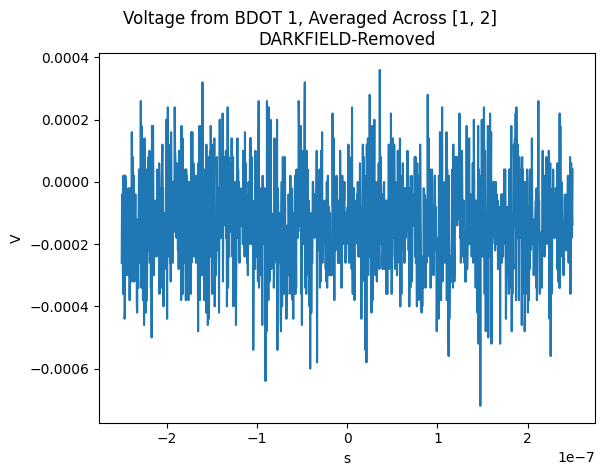

In [98]:
##################################################
# AVERAGE OSCILLOSCOPE TRACES OVER SEVERAL SHOTS #
##################################################

# USER INPUT
shot_nos_to_avg = [1, 2] #Which shot numbers would we like to average over?
bkg_shot_no = 3
bkg_shot_name = "DARKFIELD" #which background removal are we doing?
bkg_removal = True #do we want to remove the background

#bkg volts
bkg_volts = pd.read_csv(shot_path_dict[bkg_shot_no], skiprows=skiprows)[volt_key]

#divisor for arithmetic mean calculation
total_shots = len(shot_nos_to_avg)

# Open the first dataframe to initialize an empty volt_sum array
trial_df = pd.read_csv(shot_path_dict[shot_nos_to_avg[0]], skiprows=skiprows) #load 0th shot
v_axis_length = len(trial_df[volt_key]) #get length of voltage axis to initialize empty array
volt_sum = np.zeros(v_axis_length)

#Dictionary which I will use to store voltage information for each shot
voltages_dict = {} #dictionary of voltage data for each shot

#time data
time = trial_df[time_key]

for shot_no in shot_nos_to_avg:
    # Obtain voltage information for each of the shots
    shot_volts = pd.read_csv(shot_path_dict[shot_no], skiprows=skiprows)[volt_key]

    # Add shot's voltage data to the sum
    volt_sum += shot_volts

    # Store voltage data from each shot in dictionary
    voltages_dict[shot_no] = shot_volts

#Divide voltage sum by total number of shots
averaged_volts = np.multiply(volt_sum, 1/total_shots)

if bkg_removal:
    np.subtract(averaged_volts, bkg_volts)

#PLOT THE AVERAGED VOLTAGE INFORMATION
if bkg_removal:
    plt.title(f"Voltage from {DEVICE_NAME}, Averaged Across {shot_nos_to_avg}\
              \n{bkg_shot_name}-Removed")
else:
    plt.title(f"Voltage from {DEVICE_NAME}, Averaged Across {shot_nos_to_avg}")
plt.ylabel(v_units)
plt.xlabel(t_units)
plt.plot(time, averaged_volts)
plt.show() 

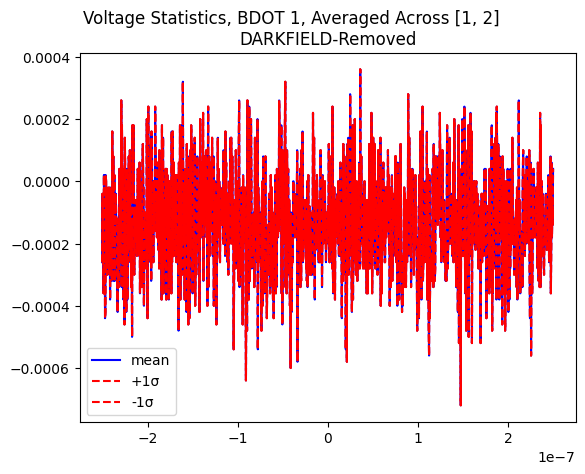

In [99]:
############################
# STATISTICS FOR THE PROBE #
############################

#Create stack of shape (shot_no, voltages length)
volt_stack = voltages_dict[shot_nos_to_avg[0]]
for shot in shot_nos_to_avg[1:]:
    volt_stack = np.stack([volt_stack, voltages_dict[shot]], axis=0)

#Create array of std voltages
std_volts = np.std(volt_stack, axis=0)
upp_bound = np.add(averaged_volts, std_volts)
low_bound = np.subtract(averaged_volts, std_volts)

#PLOT SOME STATS
if bkg_removal:
    plt.title(f"Voltage Statistics, {DEVICE_NAME}, Averaged Across {shot_nos_to_avg}\
              \n{bkg_shot_name}-Removed")
else:
    plt.title(f"Voltage Statistics, {DEVICE_NAME}, Averaged Across {shot_nos_to_avg}")
plt.plot(time, averaged_volts, color='b', label='mean')
plt.plot(time, upp_bound, ls='--', color='r', label='+1σ')
plt.plot(time, low_bound, ls='--', color='r', label='-1σ')
plt.legend()
plt.show()